# Raw Data

Purpose of this notebook is to get the data to suitable
data structure for preprocessing.

The data were taken form antares server. Concretly,
from the `/data/ccd700` directory.

## Astronomical Spectroscopy

https://en.wikipedia.org/wiki/Astronomical_spectroscopy

Spectroscopy studies properties of matter through its
interaction with different frequency components of the
electromagnetic spectrum. Astronomical spectroscopy
measures the spectrum of electromagnetic radiation of
hot celestial objects. This information is then used to
derive for example chemical composition, temperature,
distance or relative motion.

Astronomical spectroscopy measure the three major bands of
radiation:

* visible spectrum
* radio spectrum
* X-ray spectrum

Different methods are required to acquire the signal
depending on the band. For example, molecular oxygen
absorb light with walengths under 300 nm, so X-ray and
ultraviolet spectroscopy require use of setellite
telescope. Radio waves are measured by antennas or radio
dishes. Visible spectrum is obtain with telescopes such as
Ondřejov Perek 2m telescope.

## FITS file format

https://fits.gsfc.nasa.gov/fits_primer.html

Flexible Image Transport System is data format used within
astronomy for transporting, analyzing, archiving scientific
data files. It is design to store data sets consisting of
multidimensiional arrays and two dimensional tables.

In [1]:
import os
import glob
import random
import astropy.io.fits

In [2]:
raw_fits_dir = os.path.join('ondrejov-ccd700', 'raw')
# get path to all files in the dir
raw_fits_filenames = glob.glob(os.path.join(
    raw_fits_dir, '*.fit'
))
# pick random index
random_idx = random.randrange(len(raw_fits_filenames))
raw_fits_filename = raw_fits_filenames[random_idx]

### HDUs

A FITS file is comprised of segmets called Header/Data
Units (HDUs). The first HDU is called the 'Primary HDU'.
The primary data array can contain a 1-999 dimensional
array of numbers. A typical primary array could contain
a 1 dimensional **spectrum**, a 2 dimensional image,
a 3 dimensional data cube.

Any number of additional HDUs may follow the primary array.
These HDUs are referred as 'extensions'. There are three
types of standart extensions currently defined:

1. Image Extension (`XTENSION = 'IMAGE'`)
2. ASCII Table Extension (`XTENSION = 'TABLE'`)
3. Binary Table Extension (`XTENSION = 'BINTABLE'`)

In [3]:
# open file with astropy
raw_hdulist = astropy.io.fits.open(raw_fits_filename)
# display info about the HDUs
raw_hdulist.info()

Filename: ondrejov-ccd700/raw/a201506030017.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     107   (2047,)      float32   


### Header Units

Every HDU consists of an ASCII formatted 'Header Unit' and
'Data Unit'.

Each header unit contains a sequence of fixed-length 80
character long keyword record which have form:

    KEYNAME = value / comment string

Non-printing ASCII character such as tabs,
carriage-returns, line-feeds are not allowed anywhere in
the header unit.

In [4]:
raw_header = raw_hdulist[0].header
raw_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 2047 / Axis length                                    
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2015-06-04T11:11:56' / Date FITS file was generated                  
IRAF-TLM= '2015-06-04T11:11:56' / Time of last modification                     
OBJECT  = 'HD 87737'           / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSERVAT= 'ONDREJOV'           / Name of observatory (IRAF style)               
LATITUDE=             49.910

### Data Units

Note that the data unit is not required. The image pixels
in primary array or an image extension may have one of
5 supported data types:

* 8-bit (unsigned) integer bytes
* 16-bit (signed) integer bytes
* 32-bit (signed) integer bytes
* 32-bit single precision floating point real numbers
* 64-bit double precision floating point real numbers

The othe 2 standard extensions, ASCII tables and binary
tables, contain tabular information organized into rows
and columns. Binary tables are more compact and are faster
to read and write then ASCII tables.

All the entries within a column of a tables have the same
datatype. The allowed data formats for an ASCII table
column are: integer, signe and double precision floating
point value, character string. Binary table also support
logical, bit and complex data formats.

In [5]:
# show the data are one dimensional flux values
# it is in primary unit and it has one dimension
# so it is spectrum data
raw_flux = raw_hdulist[0].data
raw_flux.shape

(2047,)

The data can be ploted but it is missing correct
wavelength. To get wavelenght we use the `astropy.wcs`
module.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

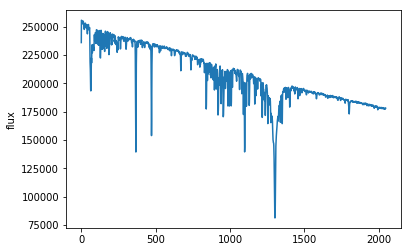

In [7]:
plt.plot(raw_flux)
plt.ylabel('flux')

In [8]:
import astropy.wcs

In [9]:
# create the WCS object from a header
raw_wcs = astropy.wcs.WCS(raw_hdulist[0].header)
# get the wavelength
# raw_header['NAXIS1'] is the number of flux points
raw_wavelen = raw_wcs.wcs_pix2world(
    range(raw_header['NAXIS1']), 0
)[0]

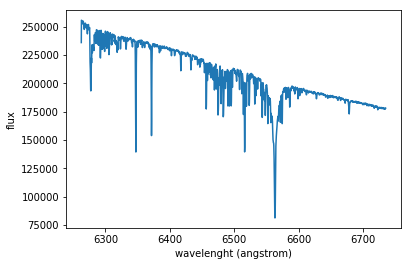

In [10]:
plt.plot(raw_wavelen, raw_flux)
plt.ylabel('flux')
plt.xlabel('wavelenght (angstrom)')

## Spetrum Normalization

In [11]:
def parse_fits_id(path):
    filename = os.path.split(path)[-1]
    identifier = os.path.splitext(filename)[0]
    return identifier

norm_fits_id = parse_fits_id(raw_fits_filename)

In [12]:
norm_fits_dir = os.path.join(
    'ondrejov-ccd700', 'normalized'
)

In [13]:
norm_fits_filename = os.path.join(
    norm_fits_dir, norm_fits_id + '.fit'
)

In [14]:
norm_hdulist = astropy.io.fits.open(norm_fits_filename)
norm_hdulist.info()

Filename: ondrejov-ccd700/normalized/a201506030017.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     104   ()              
1                BinTableHDU     19   2047R x 2C   [D, D]   


In [15]:
norm_hdulist[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                    8 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2015-06-04T11:11:56' / Date FITS file was generated                  
IRAF-TLM= '2015-06-04T11:11:56' / Time of last modification                     
OBJECT  = 'HD 87737'           / Name of the object observed                    
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
OBSERVAT= 'ONDREJOV'           / Name of observatory (IRAF style)               
LATITUDE=             49.91056 / Telescope latitude  (degrees), +49:54:38.0     
LONGITUD=             14.783

In [16]:
norm_hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 2047 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'FLUX    '                                                            
TFORM2  = 'D       '        

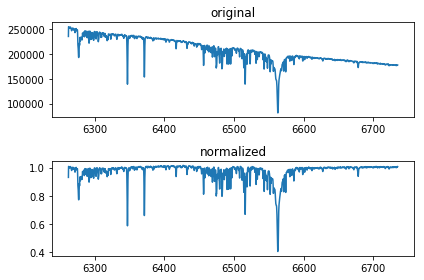

In [17]:
norm_wavelen = norm_hdulist[1].data['WAVE']
norm_flux = norm_hdulist[1].data['FLUX']
plt.subplot(2, 1, 1)
plt.title('original')
plt.plot(raw_wavelen, raw_flux)
plt.subplot(2, 1, 2)
plt.title('normalized')
plt.plot(norm_wavelen, norm_flux)
plt.tight_layout()